In [5]:
import numpy as np
import os.path as op
import glob as glob
import pandas as pd

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes, mark_inset
import seaborn as sns

from astropy.io import fits
from astropy.convolution import convolve, Gaussian1DKernel, Box1DKernel
from astropy import units as u
from astropy.coordinates import SkyCoord

In [6]:
#deine the path to save the plots
plot_path = '/Users/Briana/Documents/Grad_School/HPS/Paper_Plots'

In [7]:
files_or = glob.glob('/Volumes/BRIANA_3T/external_backup_3/HPS/LRS2_reduction_greg/reductions3/20*/lrs2/lrs2*/exp*/lrs2/spectrum_orange.fits')
files_uv = glob.glob('/Volumes/BRIANA_3T/external_backup_3/HPS/LRS2_reduction_greg/reductions3/20*/lrs2/lrs2*/exp*/lrs2/spectrum_uv.fits')
print (len(files_or))
print( len(files_uv))

0
0


In [ ]:
hps = pd.read_csv('/Users/Briana/Documents/Grad_School/HPS/HPS_dataframes/HPS_all_props.csv') #gets the redshift from obj name
obs = pd.read_csv('/Users/Briana/Documents/Grad_School/HPS/HPS_dataframes/hps_lrs2_fits_wNe_3.csv') #pairs the obj name with the observation folder

In [ ]:
hps_lrs2 = hps[hps['Source'] == 'LRS2']
print( hps_lrs2.loc[:,['HPS_name', 'z', 'Selection','LogM']])

lrs2_obs_list = hps_lrs2['HPS_name'].values

#print hps[hps['Selection'] == '[OIII]5007'].loc[:,['HPS_name','LogM']]
#print hps_lrs2[hps_lrs2['[OIII]5007'] == hps_lrs2['[OIII]5007'].max()].loc[:,['HPS_name','[OIII]5007']]
#print hps_lrs2['HPS_name'], len(hps_lrs2['HPS_name'])

In [ ]:
class lrs2_spec():
    def __init__(self, filelis_uv, filelis_or, prop_df, obs_df): 
        self.prop_df    = prop_df
        self.obs_df     = obs_df
        self.filelis_uv = filelis_uv
        self.filelis_or = filelis_or
        self.date_lis   = [i.split('/')[7] for i in filelis_uv]
        self.obj_lis    = [int(i.split('/')[9].split('s2')[1]) for i in filelis_uv]
        self.exp_lis    = [int(i.split('/')[10].split('p')[1]) for i in filelis_uv] 
        self.ind_lis    = np.arange(0,len(self.filelis_uv))
        
        self.exp_df = pd.DataFrame({'uv_file':self.filelis_uv,
                                   'or_file':self.filelis_or,
                                   'date':self.date_lis,
                                   'obs_ID':self.obj_lis,
                                   'exp':self.exp_lis,
                                   'ind':self.ind_lis})
        
        self.obj_name  = None
        self.z         = None
        self.selection = None
        
        self.wave_uv  = []
        self.wave_or  = []
        self.spec_uv  = []
        self.spec_or  = []
        
    def extract_spec(self, ind):
        file_uv = self.filelis_uv[ind]
        file_or = self.filelis_or[ind]
        self.date    = self.date_lis[ind]
        self.obj_num = self.obj_lis[ind]
        self.exp_num = self.exp_lis[ind]
        
        dat_uv, hdr_uv = fits.getdata(file_uv, 0, header=True)
        dat_or, hdr_or = fits.getdata(file_or, 0, header=True)

        nan_num = np.isnan(dat_uv).sum()
        self.obj_name = hdr_uv['OBJECT'].split('_')[0][0:16]
        self.selection = self.prop_df[self.prop_df['HPS_name']==self.obj_name]['Selection'].values[0]

        if np.isnan(dat_uv[1,:]).sum() == 0:

            self.z = self.prop_df.loc[self.prop_df['HPS_name'] == self.obj_name].z.values[0]

            self.wave_uv = dat_uv[0,:]
            self.wave_or =dat_or[0,:]
            spec_uv = dat_uv[1,:]*1e16
            spec_or = dat_or[1,:]*1e16
            
            conv_std_uv = 2.123
            conv_std_or = 2.123
            
            conv_std_uv = 1.0
            conv_std_or = 1.0
            
            gauss_kernel_uv = Gaussian1DKernel(conv_std_uv)
            gauss_kernel_or = Gaussian1DKernel(conv_std_or)
            self.spec_uv = convolve(spec_uv, gauss_kernel_uv)
            self.spec_or = convolve(spec_or, gauss_kernel_or)

            return self.spec_uv, self.spec_or, self.wave_uv, self.wave_or
        
    def combine_spec(self, HPS_name):
        inds = self.obs_df[self.obs_df['HPS_name']==HPS_name]['Obs_ID'].values
        obs_dates = [i.split('_')[0] for i in inds]
        obs_objs  = [int(i.split('_')[1].split('s')[1]) for i in inds]
        obs_exp   = [int(i.split('_')[2].split('p')[1]) for i in inds]
        
        uv_s_lis = []
        or_s_lis = []
        uv_w_lis = []
        or_w_lis = []
        
        for j in range(len(inds)):
            exp_ind = self.exp_df[(self.exp_df['date']==obs_dates[j]) & (self.exp_df['obs_ID']==obs_objs[j]) & (self.exp_df['exp']==obs_exp[j])]['ind'].values
            uv_s, or_s, uv_w, or_w = self.extract_spec(exp_ind[0])
            uv_s_lis.append(uv_s)
            or_s_lis.append(or_s)
            uv_w_lis.append(uv_w)
            or_w_lis.append(or_w)
            
        #check that the wavelength solutions are the same for all 
        #if they are save the solution 
        uv_w_stack = np.vstack(uv_w_lis)
        or_w_stack = np.vstack(or_w_lis)
        if np.isclose(uv_w_stack, uv_w_stack[0]).all():
            self.wave_uv = uv_w_lis[0]
        else:
            print ('Different Orange wl solutions')
        if np.isclose(or_w_stack, or_w_stack[0]).all():
            self.wave_or = or_w_lis[0]
        else:
            print ('Different Orange wl solutions')
            
        #combine the orange and uv spectra 
        uv_s_stack = np.vstack(uv_s_lis)
        or_s_stack = np.vstack(or_s_lis)
        self.spec_uv = np.median(uv_s_stack, axis=0)
        self.spec_or = np.median(or_s_stack, axis=0) 
            
    def plot_obj(self, ax, zoom, save=None):
        
        cp = sns.color_palette()
        
        txt_font = 17
        
        line_label = zoom[1] - 0.2
        
        #plot the spectrum        
        ax.plot(self.wave_uv, self.spec_uv, label='z '+str(self.z), color=cp[0])
        ax.plot(self.wave_or, self.spec_or, label='z '+str(self.z), color=cp[1])
        
        ax.set_xlim(3400,7200)
        ax.set_ylim(-0.5, 2.5)

        #plot the emission lines markers
        y_vals = np.linspace(-1, np.max(self.spec_or*10), 50)
        ax.plot(np.zeros(50)+(3727*(1+float(self.z))), y_vals, color=cp[7], ls=':')
        ax.plot(np.zeros(50)+(3869*(1+float(self.z))), y_vals, color=cp[7], ls=':')
        ax.plot(np.zeros(50)+(4861*(1+float(self.z))), y_vals, color=cp[7], ls=':')
        ax.plot(np.zeros(50)+(4959*(1+float(self.z))), y_vals, color=cp[7], ls=':')
        ax.plot(np.zeros(50)+(5007*(1+float(self.z))), y_vals, color=cp[7], ls=':')
        ax.fill_betweenx(y_vals, np.zeros(50)+5564, np.zeros(50)+5592, color=cp[7], alpha=0.4, zorder=1000)

        #create UV zoom in
        axins_uv = inset_axes(ax, 5, 2, loc=2)
        axins_uv.plot(self.wave_uv, self.spec_uv, color=cp[0])
        axins_uv.plot(np.zeros(50)+(3727*(1+float(self.z))), y_vals, color=cp[7], ls=':')
        axins_uv.plot(np.zeros(50)+(3869*(1+float(self.z))), y_vals, color=cp[7], ls=':')
        
        axins_uv.text(3718*(1+float(self.z)), line_label, 'OII[3727]', fontsize=txt_font, color='black')
        axins_uv.text(3850*(1+float(self.z)), line_label, 'NeIII[3869]', fontsize=txt_font, color='black')

        #specify UV zoom in box size
        axins_uv.set_xlim(3695*(1+float(self.z)), 3905*(1+float(self.z)))
        axins_uv.set_ylim(zoom[0], zoom[1])
        mark_inset(ax, axins_uv, loc1=2, loc2=4, fc="none", ec="0.5")
        
        plt.yticks(visible=False)
        plt.xticks(visible=False)
        
        #create ORANGE zoom in
        axins_or = inset_axes(ax, 5, 2, loc=1)
        axins_or.plot(self.wave_or, self.spec_or, color=cp[1])
        axins_or.plot(np.zeros(50)+(4861*(1+float(self.z))), y_vals, color=cp[7], ls=':')
        axins_or.plot(np.zeros(50)+(4959*(1+float(self.z))), y_vals, color=cp[7], ls=':')
        axins_or.plot(np.zeros(50)+(5007*(1+float(self.z))), y_vals, color=cp[7], ls=':')
        axins_or.fill_betweenx(y_vals, np.zeros(50)+5564, np.zeros(50)+5592, color=cp[7], alpha=0.4, zorder=1000)
        
        axins_or.text(4852*(1+float(self.z)), line_label, r'$H\beta$', fontsize=txt_font, color='black')
        axins_or.text(4940*(1+float(self.z)), line_label-0.15, 'OIII[4959]', fontsize=txt_font, color='black')
        axins_or.text(4990*(1+float(self.z)), line_label+0.05, 'OIII[5007]', fontsize=txt_font, color='black')

        #specify ORANGE zoom in box size
        axins_or.set_xlim(4820*(1+float(self.z)), 5040*(1+float(self.z)))
        axins_or.set_ylim(zoom[0], zoom[1])
        mark_inset(ax, axins_or, loc1=2, loc2=4, fc="none", ec="0.5")
        
        plt.yticks(visible=False)
        plt.xticks(visible=False)
        
        ax.set_xticklabels(ax.get_xticks(), fontsize=25)
        ax.set_yticklabels(ax.get_yticks(), fontsize=25)
        ax.set_xlabel(r'$Wavelength\ \AA$', fontsize=30, fontweight='bold')
        ax.set_ylabel(r'$Flux\ (ergs/s/cm^2/\AA)\ (x{10}^{-16})$', fontsize=25, fontweight='bold')
        ax.set_title(self.obj_name+' ('+self.selection+' selected)'+' (z='+str(self.z)+')', fontsize=35, fontweight='bold')
        
        if save != None:
            plt.savefig(save, bbox_inches='tight')
    
        plt.show()

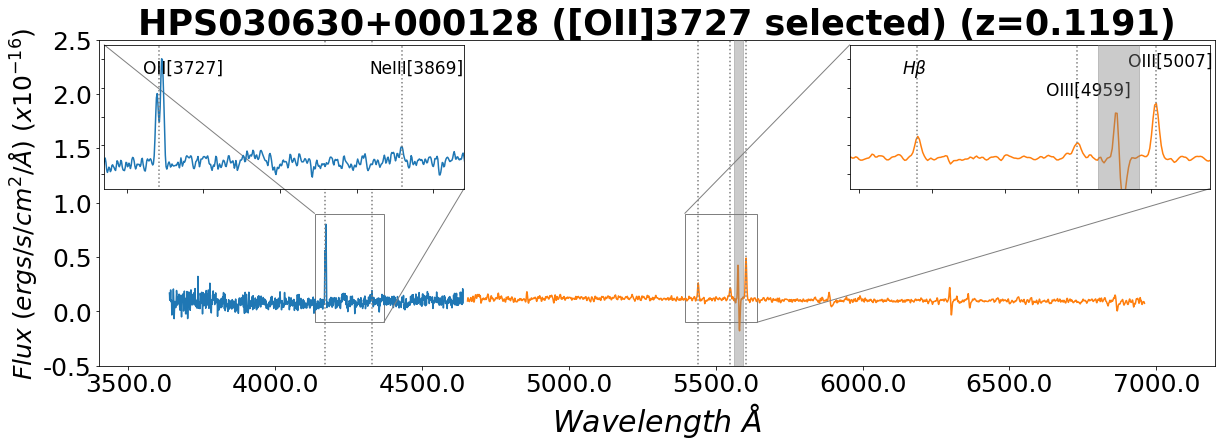

In [64]:
hps_ex = 'HPS030630+000128'

file1 = lrs2_spec(files_uv, files_or, hps, obs)
#file1.extract_spec(ind=30)
file1.combine_spec(HPS_name=hps_ex) 
fig, ax = plt.subplots(figsize=(20,6))
file1.plot_obj(ax, (-0.1, 0.9))

In [4]:
for l in lrs2_obs_list:
    file1 = lrs2_spec(files_uv, files_or, hps, obs)
    file1.combine_spec(HPS_name=l)
    fig, ax = plt.subplots(figsize=(20,6))
    file1.plot_obj(ax, (-0.1, 0.6))

NameError: name 'lrs2_obs_list' is not defined

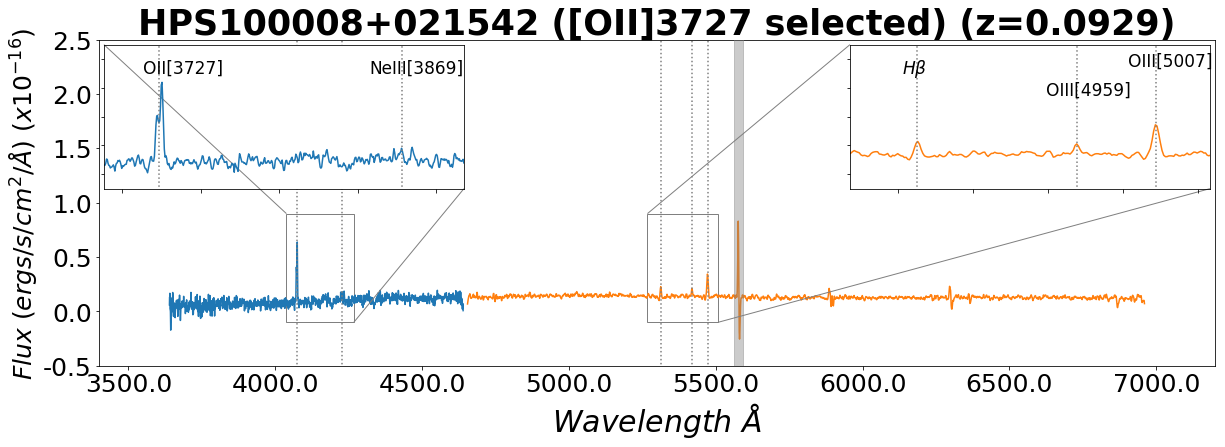

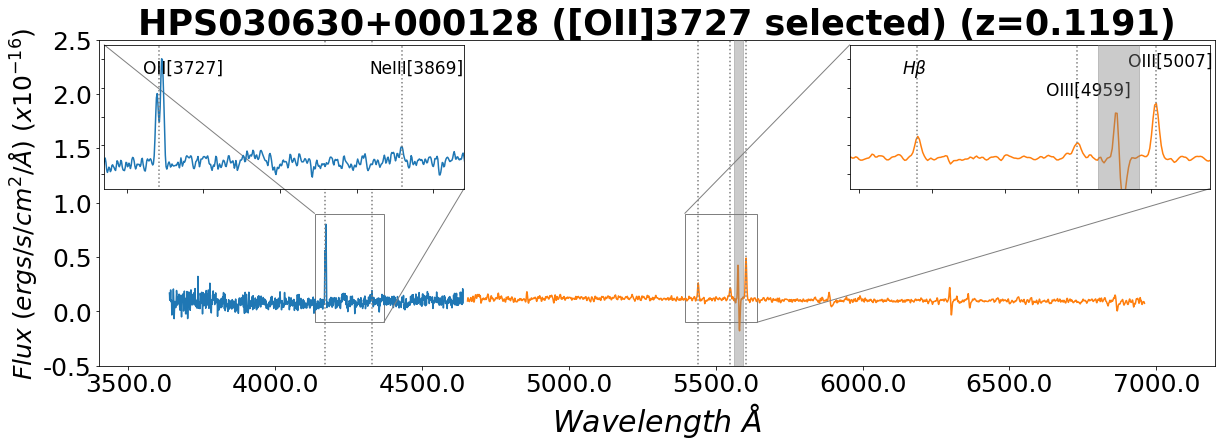

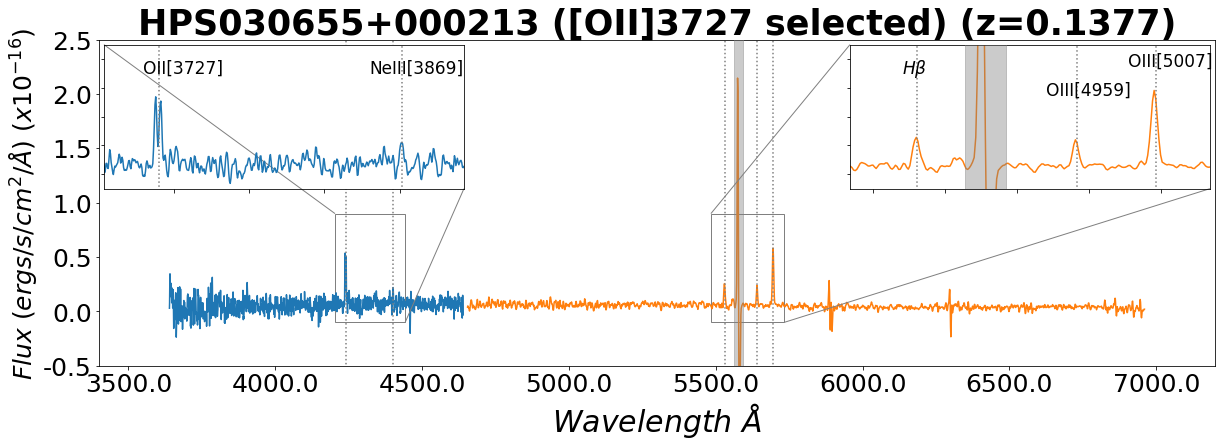

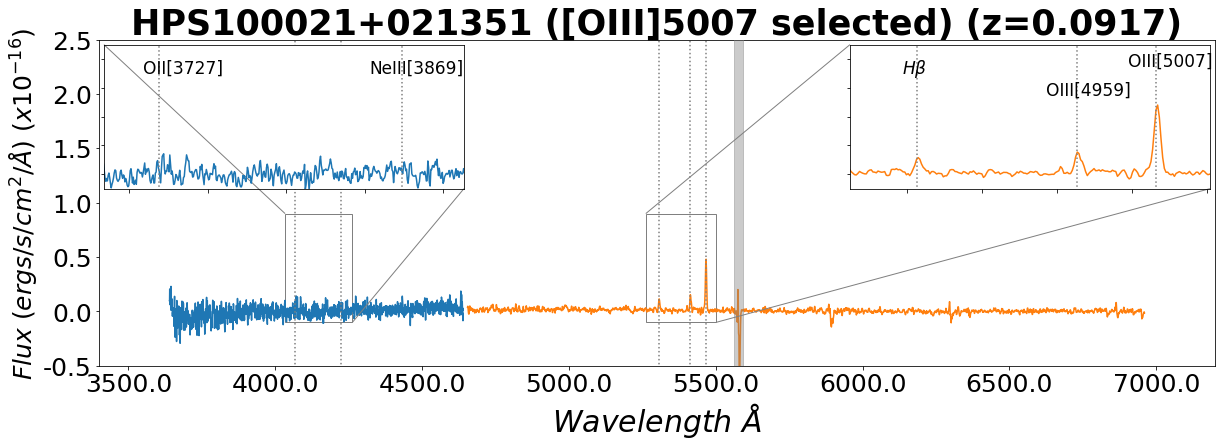

In [65]:
hps_lis = ['HPS100008+021542', 'HPS030630+000128', 'HPS030655+000213', 'HPS100021+021351']
for h in hps_lis:
    file1 = lrs2_spec(files_uv, files_or, hps, obs)
    #file1.extract_spec(ind=30)
    file1.combine_spec(HPS_name=h) 
    fig, ax = plt.subplots(figsize=(20,6))
    file1.plot_obj(ax, (-0.1, 0.9), save=op.join(plot_path, 'LRS2_spec_'+h+'.pdf'))

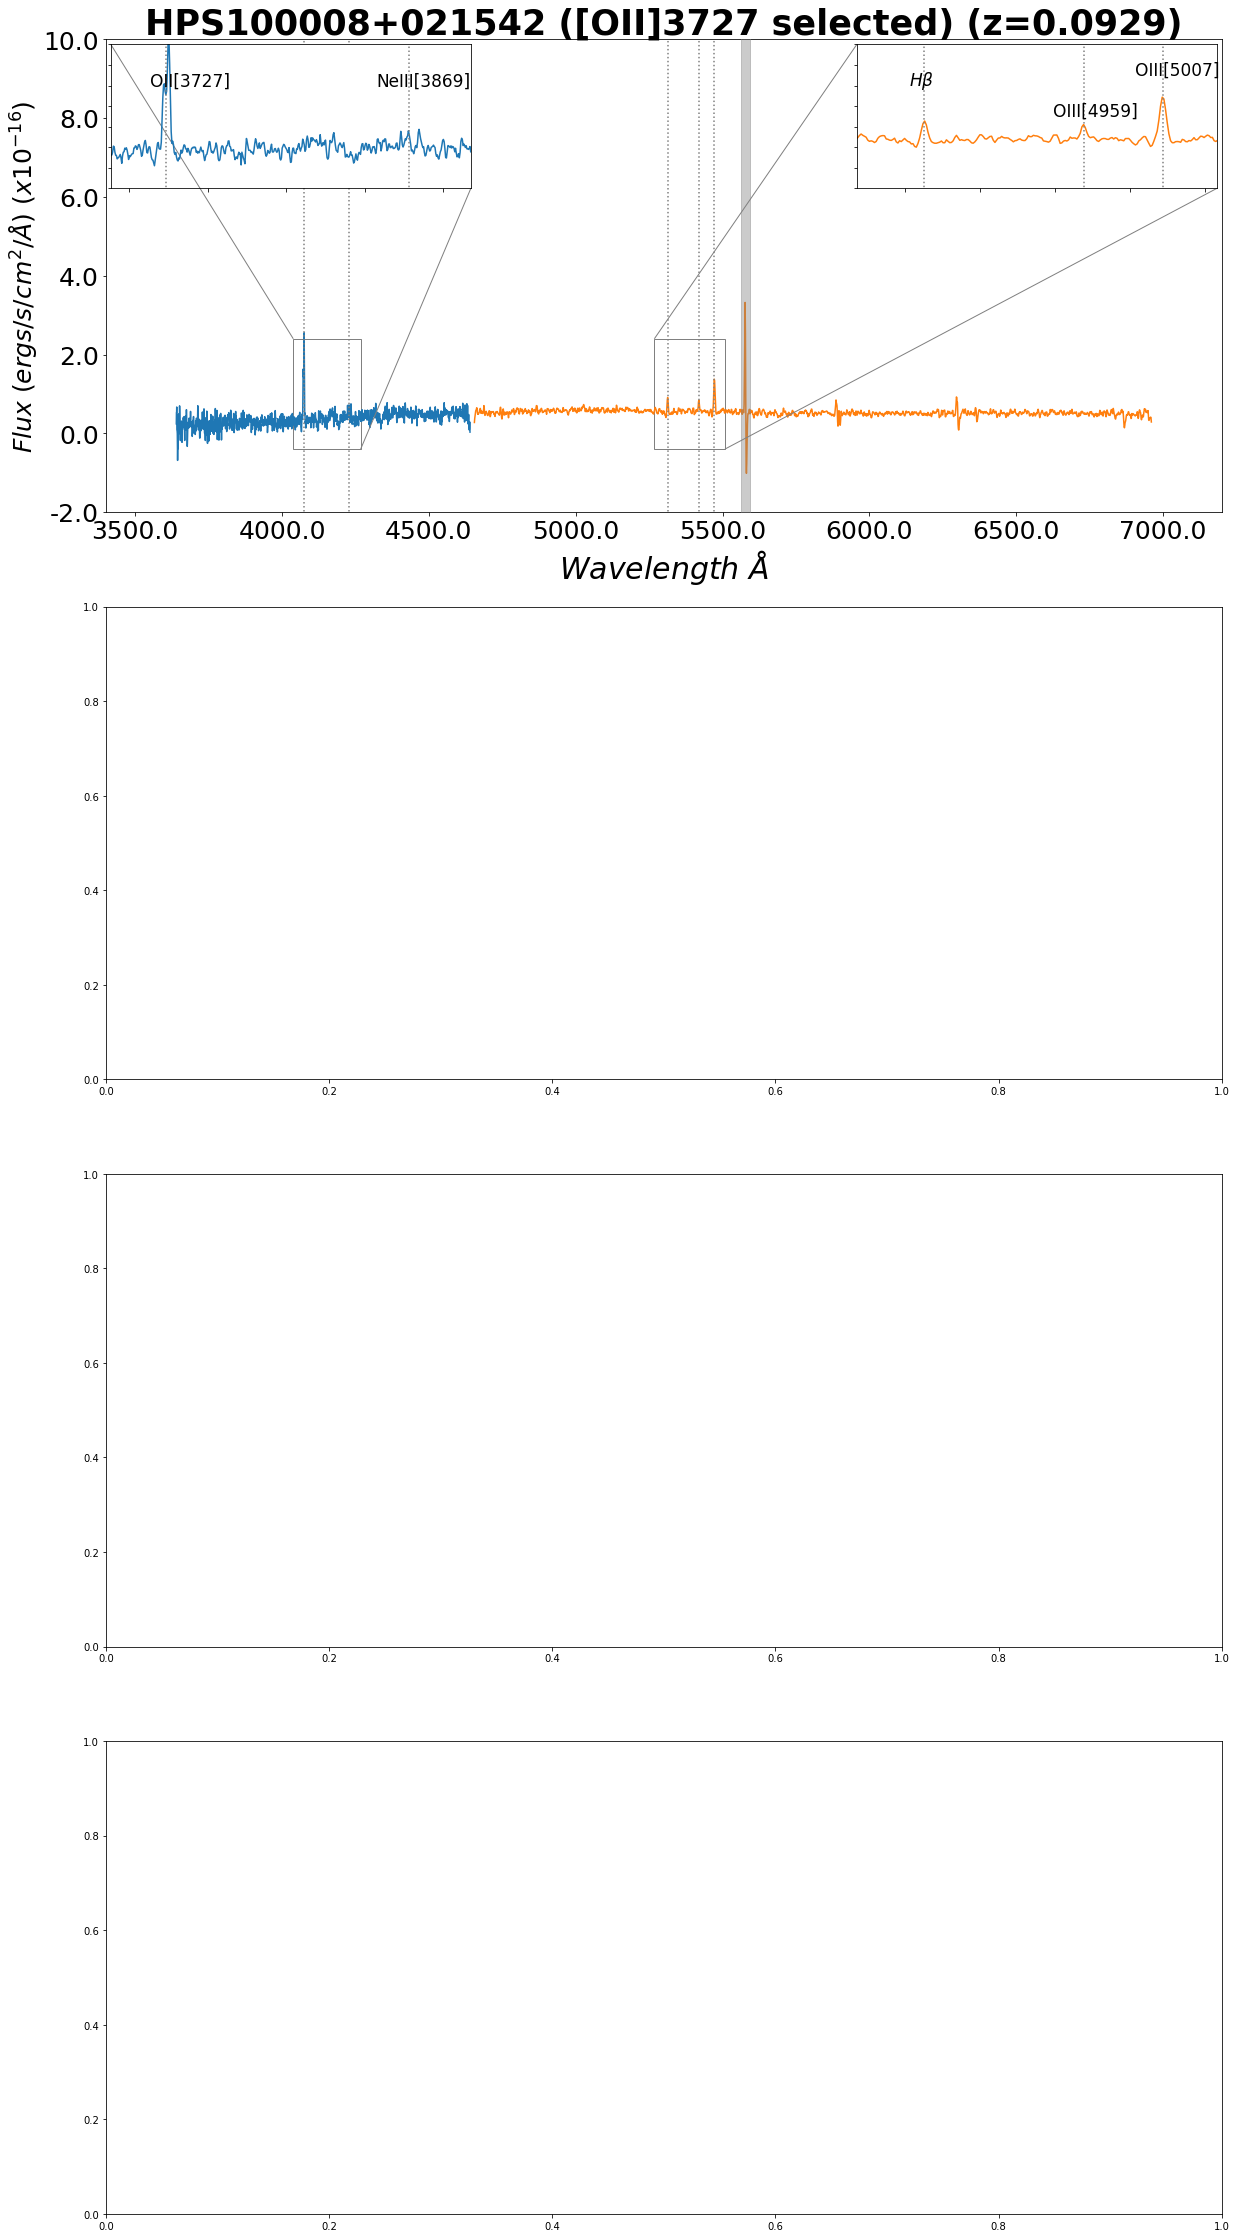

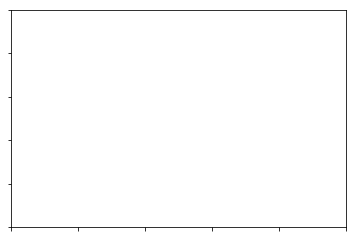

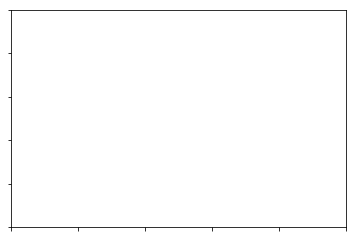

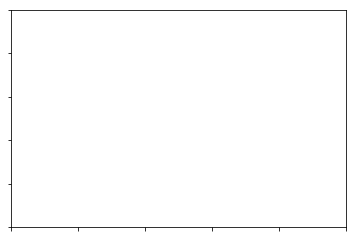

In [16]:
#Build the paper subplot 
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(20, 40))

#ax_lis  = [ax1, ax2, ax3, ax4]
hps_lis = ['HPS100008+021542', 'HPS030630+000128', 'HPS030655+000213', 'HPS100021+021351']
for h in range(len(hps_lis)):
    file1 = lrs2_spec(files_uv, files_or, hps, obs)
    file1.combine_spec(HPS_name=hps_lis[h])
    file1.plot_obj(axes[h], (-0.1, 0.6))

# Same but if you have red data

In [66]:
class lrs2_spec_red():
    def __init__(self, filelis_uv, filelis_or, filelis_re, prop_df): 
        self.prop_df    = prop_df
        self.filelis_uv = filelis_uv
        self.filelis_or = filelis_or
        self.filelis_re = filelis_re
        
        self.obj_name  = None
        self.z         = None
        self.selection = None
        
        self.wave_uv  = []
        self.wave_or  = []
        self.wave_re  = []
        self.spec_uv  = []
        self.spec_or  = []
        self.spec_re  = []
        
    def extract_spec(self, ind):
        file_uv = self.filelis_uv[ind]
        file_or = self.filelis_or[ind]
        file_re = self.filelis_re[ind]
        
        dat_uv, hdr_uv = fits.getdata(file_uv, 0, header=True)
        dat_or, hdr_or = fits.getdata(file_or, 0, header=True)
        dat_re, hdr_re = fits.getdata(file_re, 0, header=True)

        nan_num = np.isnan(dat_uv).sum()
        self.obj_name = hdr_uv['OBJECT'].split('_')[0][0:16]
        self.selection = self.prop_df[self.prop_df['HPS_name']==self.obj_name]['Selection'].values[0]

        if np.isnan(dat_uv[1,:]).sum() == 0:

            self.z = self.prop_df.loc[self.prop_df['HPS_name'] == self.obj_name].z.values[0]

            self.wave_uv = dat_uv[0,:]
            self.wave_or =dat_or[0,:]
            self.wave_re =dat_re[0,:]
            self.spec_uv = dat_uv[1,:]*1e16
            self.spec_or = dat_or[1,:]*1e16
            self.spec_re = dat_re[1,:]*1e16
            
            self.spec_uv = self.spec_uv-0.08

            return self.spec_uv, self.spec_or, self.spec_re, self.wave_uv, self.wave_or, self.wave_re
    
    def plot_obj(self, ax, zoom, save=None):
        
        cp = sns.color_palette()
        
        txt_font = 17
        
        line_label = zoom[1] - 0.2
        real_z = self.z
        self.z = self.z+0.0004
        
        #plot the spectrum        
        ax.plot(self.wave_uv, self.spec_uv, label='z '+str(self.z), color=cp[0])
        ax.plot(self.wave_or, self.spec_or, label='z '+str(self.z), color=cp[1])
        ax.plot(self.wave_re, self.spec_re, label='z '+str(self.z), color=cp[3])
        
        ax.set_xlim(3500,8500)
        ax.set_ylim(-0.5, 2.5)

        #plot the emission lines markers
        strong_lines = [3727, 3869, 4861, 4959, 5007, 6562, 6549, 6583]
        y_vals = np.linspace(-1, np.max(self.spec_or*10), 50)
        for s in strong_lines:
            #checks what strong lines are in the given channel 
            s = s*(1.0+float(self.z))
            ax.plot(np.zeros(50)+s, y_vals, color=cp[7], ls=':')
        
        ax.fill_betweenx(y_vals, np.zeros(50)+5564, np.zeros(50)+5592, color=cp[7], alpha=0.4, zorder=1000)

        #create UV zoom in
        axins_uv = inset_axes(ax, 5, 2, loc=2)
        axins_uv.plot(self.wave_uv, self.spec_uv, color=cp[0])
        axins_uv.plot(np.zeros(50)+(3727*(1+float(self.z))), y_vals, color=cp[7], ls=':')
        axins_uv.plot(np.zeros(50)+(3869*(1+float(self.z))), y_vals, color=cp[7], ls=':')
        
        axins_uv.text(3718*(1+float(self.z)), line_label, 'OII[3727]', fontsize=txt_font, color='black')
        axins_uv.text(3845*(1+float(self.z)), line_label, 'NeIII[3869]', fontsize=txt_font, color='black')

        #specify UV zoom in box size
        axins_uv.set_xlim(3695*(1+float(self.z)), 3905*(1+float(self.z)))
        axins_uv.set_ylim(zoom[0], zoom[1])
        mark_inset(ax, axins_uv, loc1=2, loc2=4, fc="none", ec="0.5")
        
        plt.yticks(visible=False)
        plt.xticks(visible=False)
        
        #create ORANGE zoom in
        axins_or = inset_axes(ax, 5, 2, loc=9)
        axins_or.plot(self.wave_or, self.spec_or, color=cp[1])
        axins_or.plot(np.zeros(50)+(4861*(1+float(self.z))), y_vals, color=cp[7], ls=':')
        axins_or.plot(np.zeros(50)+(4959*(1+float(self.z))), y_vals, color=cp[7], ls=':')
        axins_or.plot(np.zeros(50)+(5007*(1+float(self.z))), y_vals, color=cp[7], ls=':')
        axins_or.fill_betweenx(y_vals, np.zeros(50)+5564, np.zeros(50)+5592, color=cp[7], alpha=0.4, zorder=1000)
        
        axins_or.text(4852*(1+float(self.z)), line_label, r'$H\beta$', fontsize=txt_font, color='black')
        axins_or.text(4950*(1+float(self.z)), line_label-0.15, 'OIII[4959]', fontsize=txt_font, color='black')
        axins_or.text(4985*(1+float(self.z)), line_label+0.05, 'OIII[5007]', fontsize=txt_font, color='black')

        #specify ORANGE zoom in box size
        axins_or.set_xlim(4820*(1+float(self.z)), 5040*(1+float(self.z)))
        axins_or.set_ylim(zoom[0], zoom[1])
        mark_inset(ax, axins_or, loc1=2, loc2=4, fc="none", ec="0.5")
        
        plt.yticks(visible=False)
        plt.xticks(visible=False)
        
        #create RED zoom in
        axins_re = inset_axes(ax, 5, 2, loc=1)
        axins_re.plot(self.wave_re, self.spec_re, color=cp[3])
        axins_re.plot(np.zeros(50)+(6562*(1+float(self.z))), y_vals, color=cp[7], ls=':')
        axins_re.plot(np.zeros(50)+(6549*(1+float(self.z))), y_vals, color=cp[7], ls=':')
        axins_re.plot(np.zeros(50)+(6583*(1+float(self.z))), y_vals, color=cp[7], ls=':')
   
        axins_re.text(6560*(1+float(self.z)), line_label, r'$H\alpha$', fontsize=txt_font, color='black')
        axins_re.text(6540*(1+float(self.z)), line_label, 'NII[6549]', fontsize=txt_font, color='black')
        axins_re.text(6574*(1+float(self.z)), line_label, 'NII[6583]', fontsize=txt_font, color='black')

        #specify RED zoom in box size
        axins_re.set_xlim(6520*(1+float(self.z)), 6600*(1+float(self.z)))
        axins_re.set_ylim(zoom[0], zoom[1])
        mark_inset(ax, axins_re, loc1=2, loc2=4, fc="none", ec="0.5")
        
        plt.yticks(visible=False)
        plt.xticks(visible=False)
        
        ax.set_xticklabels(ax.get_xticks(), fontsize=25)
        ax.set_yticklabels(ax.get_yticks(), fontsize=25)
        ax.set_xlabel(r'$Wavelength\ \AA$', fontsize=30, weight='bold')
        ax.set_ylabel(r'$Flux\ (ergs/s/cm^2/\AA)\ (x{10}^{-16})$', fontsize=25, weight='bold')
        ax.set_title(self.obj_name+' ('+self.selection+' selected)'+' (z='+str(real_z)+')', fontsize=35, weight='bold')
        
        if save != None:
            plt.savefig(save, bbox_inches='tight')
    
        plt.show()

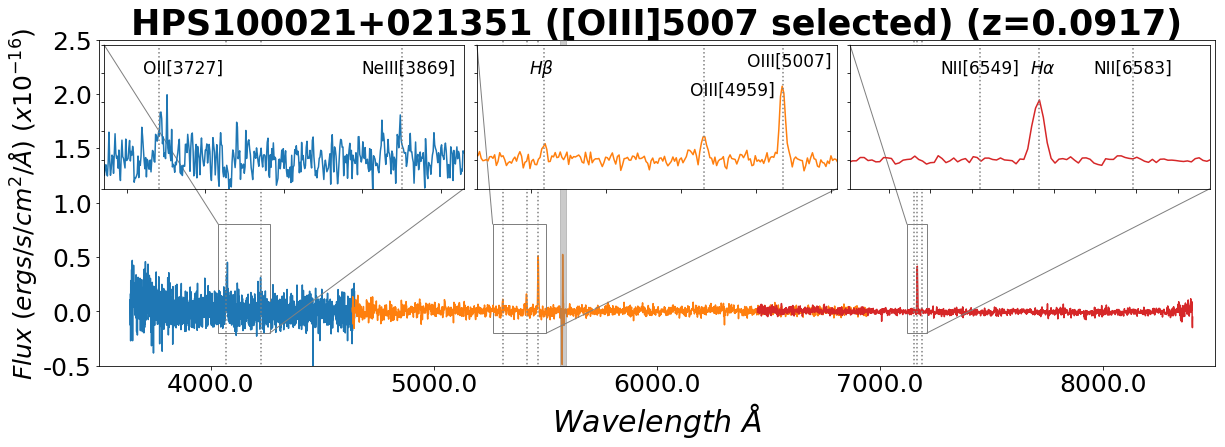

In [67]:
datapath = '/Users/Briana/Documents/Grad_School/HPS/LRS2_reductions/OIII_objects/*/lrs2/lrs2*/exp*/lrs2/'

hps_obj = 'HPS100021+021351'

date = '20190126' #'20190202'
blu_obs = '0000023' #'0000016'
red_obs = '0000024' #'0000017'

files_uv = glob.glob(datapath+'spectrum_20190126_0000023_exp01_uv.fits')
files_or = glob.glob(datapath+'spectrum_20190126_0000023_exp01_orange.fits')
files_re = glob.glob(datapath+'spectrum_20190126_0000024_exp01_red.fits')

file1 = lrs2_spec_red(files_uv, files_or, files_re, hps)
file1.extract_spec(0)
fig, ax = plt.subplots(figsize=(20,6))
file1.plot_obj(ax, zoom=(-0.2, 0.8), save=op.join(plot_path, 'LRS2_spec_'+hps_obj+'_wRed.pdf'))
